In [8]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Styling for a professional look
sns.set_theme(style="white")
plt.rcParams['figure.figsize'] = (12, 6)

In [9]:
# Load and Clean Data
# Load the datasets
sentiment = pd.read_csv('fear_greed_index.csv')
trades = pd.read_csv('historical_data.csv')

# Format dates: Sentiment has 'date', Trades has 'Timestamp IST'
sentiment['date'] = pd.to_datetime(sentiment['date'])
trades['date'] = pd.to_datetime(trades['Timestamp IST'], dayfirst=True).dt.normalize()

print(f"Data Loaded: {len(trades)} trades across {len(sentiment)} days of sentiment data.")

Data Loaded: 211224 trades across 2644 days of sentiment data.


In [10]:
# Feature Engineering (Daily Metrics)
# Aggregate trade data to a daily level per account
daily_metrics = trades.groupby(['Account', 'date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    total_vol=('Size USD', 'sum'),
    avg_trade_size=('Size USD', 'mean'),
    trade_count=('Trade ID', 'count')
).reset_index()

# Calculate Win Rate (Frequency of positive PnL trades)
closed_trades = trades[trades['Closed PnL'] != 0].copy()
closed_trades['is_win'] = (closed_trades['Closed PnL'] > 0).astype(int)
win_rates = closed_trades.groupby(['Account', 'date'])['is_win'].mean().reset_index()
win_rates.rename(columns={'is_win': 'win_rate'}, inplace=True)

# Merge everything together
df = pd.merge(daily_metrics, win_rates, on=['Account', 'date'], how='left').fillna(0)

# Join with the Fear & Greed Index
final_df = pd.merge(df, sentiment[['date', 'value', 'classification']], on='date')
final_df.rename(columns={'value': 'fg_score', 'classification': 'sentiment_label'}, inplace=True)

# Segmenting Traders into "Pros" (Total Profit > 0) vs "Retail"
total_performance = final_df.groupby('Account')['daily_pnl'].sum()
final_df['trader_type'] = final_df['Account'].map(lambda x: 'Pro' if total_performance[x] > 0 else 'Retail')

print("Data processing complete. Metrics generated.")

Data processing complete. Metrics generated.


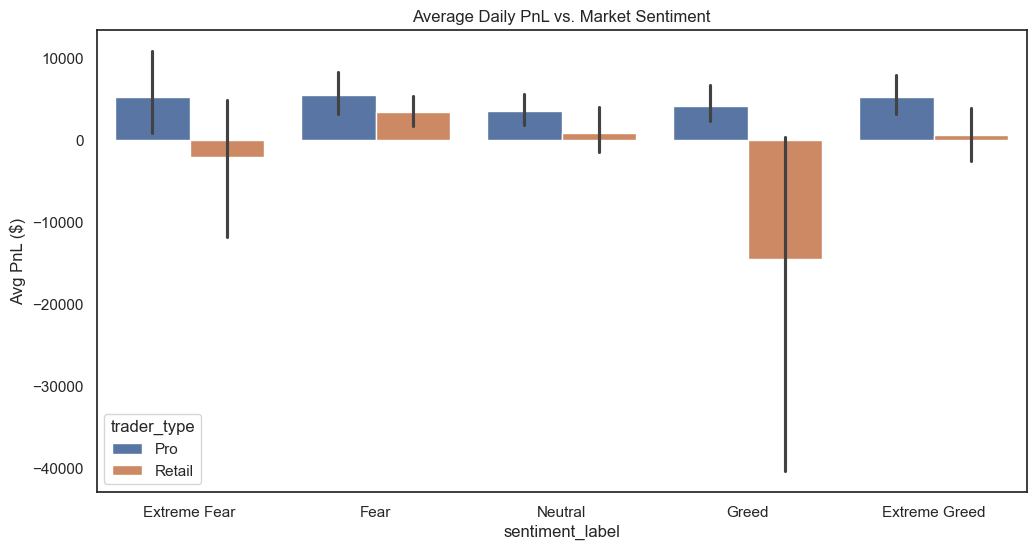

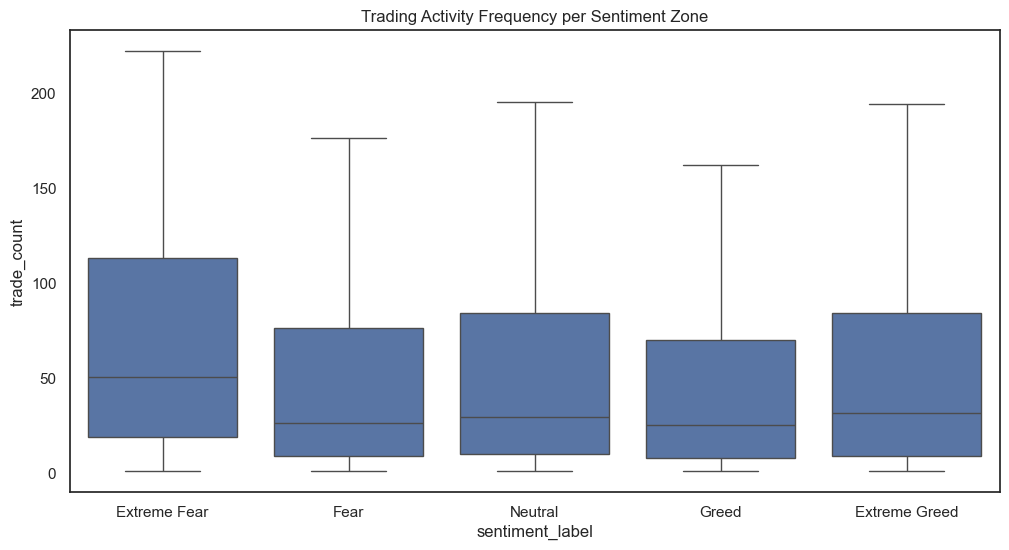

In [11]:
# Visualizing Findings
# Insight 1: Performance vs Sentiment
plt.figure()
order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
sns.barplot(data=final_df, x='sentiment_label', y='daily_pnl', hue='trader_type', order=order)
plt.title('Average Daily PnL vs. Market Sentiment')
plt.ylabel('Avg PnL ($)')
plt.show()

# Insight 2: Behavior (Trade Count)
plt.figure()
sns.boxplot(data=final_df, x='sentiment_label', y='trade_count', order=order, showfliers=False)
plt.title('Trading Activity Frequency per Sentiment Zone')
plt.show()

In [12]:
# Predictive Model (Bonus)
# Predict if a trader will be profitable tomorrow
final_df = final_df.sort_values(['Account', 'date'])
final_df['target_profitable'] = (final_df.groupby('Account')['daily_pnl'].shift(-1) > 0).astype(int)

# Drop rows with no "tomorrow" data
ml_data = final_df.dropna(subset=['target_profitable'])

features = ['fg_score', 'trade_count', 'avg_trade_size', 'win_rate']
X = ml_data[features]
y = ml_data['target_profitable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print(f"Next-Day Profitability Prediction Accuracy: {model.score(X_test, y_test):.2%}")

Next-Day Profitability Prediction Accuracy: 62.82%
